# <a id='toc1_'></a>[02: Clustering of product catalogs with Agglomerative Clustering and t-SNE](#toc0_)

In this notebook, we will introduce our first approach product clustering using hierarchical clustering of catalogs and size titles as labels. This notebook will discuss:
- Problem statement and relevance
- Definition and Formulation of Agglomerative Clustering
- Flattening of hierarchical clusters and visualization
- Comparison of t-SNE (manifold learning) and PCA (dimensionality reduction) for data visualization in lower dimensional space
- Analysis of the results

**Keywords**: Agglomerative Clustering, Hierarchical Clustering, t-SNE, Vinted


**Table of contents**<a id='toc0_'></a>    
- [02: Clustering of product catalogs with Agglomerative Clustering and t-SNE](#toc1_)    
  - [Introduction](#toc1_1_)    
    - [Product catalogs and title sizes](#toc1_1_1_)    
  - [Preprocessing](#toc1_2_)    
    - [Loading the data and required packages](#toc1_2_1_)    
    - [The Dataset](#toc1_2_2_)    
    - [Data preparation](#toc1_2_3_)    
  - [Agglomerative Hierarchical Clustering using Ward Linkage](#toc1_3_)    
    - [Ward Linkage Method](#toc1_3_1_)    
    - [Dendrogram visualization](#toc1_3_2_)    
    - [Analysis of Sizing Features](#toc1_3_3_)    
  - [Visualizing the clusters](#toc1_4_)    
    - [t-Distributed Stochastic Neighbor Embedding (manifold embedding technique)](#toc1_4_1_)    
    - [Visualizing the clustering on 2 dimensions using PCA](#toc1_4_2_)    
    - [Comparison of the methods](#toc1_4_3_)    
  - [Analysis of the results](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

![Image Description](../assets/catalog_clustering.png)

The problem we aim to solve here is to cluster product catalogs into higher levels of catalogs. By nature, Vinted already has an hierarchical sequence of natural catalogs. For instance, the primary labels are: Woman, Men, Children, House, Animals, Others

- Woman -> Bras, dresses, leggings, pantyhoses, as well as common clothes (trousers, shirts, shoes, etc)
- Men -> Shoes, shorts, t shirts, shirts, etc
- Children -> same as above
- House -> blankets, towels, pillows, decoration, etc
- Animals -> Toys, grooming, training, etc
- Entertainment -> ...

In addition, this hierarchies have 4 to 5 layers of depth.

- Men -> Shoes -> Sneakers -> Sports sneakers
- Men -> Clothing -> T shirts and tops -> T shirts -> Simple T shirts

### <a id='toc1_1_1_'></a>[Product catalogs and title sizes](#toc0_)

After skimming through the data, I realized the best segmentation feature here is the title sizes. Each category is often linked to a specific size title. Sometimes its very obvious (shoes vs clothing), specially in higher level segmentation; sometimes it can be trickier (women shoes vs men shoes).

As an example:
- M, XL, S, etc which are the standard clothing sizes 
    - But sizes differ between men and women
- no_size for the products which do not have size labels
    - Impossible to distinguish no_size title based on sizing alone
- numeric sizes (40, 41) which refers to footwear
- kids sizes (8 anos, 12 anos, etc)
- cup sizes (95D, 80B)
- jewelry (which im assuming 30 mm diameter refers to)
- volume units (40 x 45 cm)
- weight units (9-18kgs)
- jeans sizes (waist measurements W33)
    - But sizes differ between men and women

## <a id='toc1_2_'></a>[Preprocessing](#toc0_)

### <a id='toc1_2_1_'></a>[Loading the data and required packages](#toc0_)

In [43]:
# importing base packages
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import numpy as np

# clustering packages
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import numpy as np

# visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#import plotly.figure_factory as ff
import plotly.express as px
from sklearn.manifold import TSNE
import ipywidgets as widgets
from IPython.display import display

from sklearn.decomposition import TruncatedSVD
import pandas as pd

%matplotlib inline

In [44]:
def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""SELECT brand_title, price_numeric, catalog_id, size_title
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               LIMIT 500000
               """
data = pd.read_sql(sql_query, engine)
data.head(5)

,brand_title,price_numeric,catalog_id,size_title
0,Nike ACG,80.0,585.0,L
1,Nike ACG,125.0,1080.0,XL / 42 / 14
2,L’Art de L’Automobile,290.0,582.0,XL
3,Nike,75.0,584.0,XL
4,Nike ACG,75.0,585.0,L


### <a id='toc1_2_2_'></a>[The Dataset](#toc0_)

The dataset used is the Vinted dataset. For this purpose, we are selecting only these variables.

| Variable           | Description       | Range/Unit            |
|--------------------|-------------------|-----------------------|
| brand_title        | Brand           | Char (category)      |
| price_numeric      | Base price           | Numeric    |
| catalog_id         | Catalog       | Numeric (category) |
| size_title         | Size        | Char (category)                 |

In [45]:
data.isna().sum()

brand_title      17
price_numeric    17
catalog_id       17
size_title       17
dtype: int64

In [46]:
data[["brand_title", "size_title"]].nunique()

brand_title    8611
size_title      301
dtype: int64

### <a id='toc1_2_3_'></a>[Data preparation](#toc0_)

Before we start, we need to clean and reshape the data to a preferred format. For this purpose we are using only the sizes as clustering dimensions, because we understand different sizing plays a huge role in product catalogs and reflects other latent variables such as gender, age and type.


The most reasonable metric here is count of each product per size title since price is subjective and affected by other factors. If we were to chose median price or volume, it could be more easily affected by exegenous variables.

In [47]:
data.dropna(axis = 0, inplace= True)
data

,brand_title,price_numeric,catalog_id,size_title
0,Nike ACG,80.0,585.0,L
1,Nike ACG,125.0,1080.0,XL / 42 / 14
2,L’Art de L’Automobile,290.0,582.0,XL
3,Nike,75.0,584.0,XL
4,Nike ACG,75.0,585.0,L
...,...,...,...,...
499995,Puma,8.0,1662.0,10 anos / 140 cm
499996,Ralph Lauren,30.0,1663.0,7 anos / 122 cm
499997,Puma,8.0,1201.0,10 anos / 140 cm
499998,Save The Duck,30.0,2576.0,12 anos / 152 cm


In [48]:
# using product count as metric
pivot_size = data.pivot_table(values='price_numeric', columns='size_title', index='catalog_id', aggfunc='count')
pivot_size.head(5)

size_title,,0-13 kg,"0-3 meses, 30 cm","1-2 anos, 49 cm",1-3 meses / 56 cm,10,10 anos / 140 cm,100 cm,100 x 150 cm,100B,100E,105 cm,11 anos / 146 cm,11-25 kg,110 cm,115 cm,12 anos / 152 cm,12 ou mais > 56 cm,12-18 meses / 80 cm,120 cm,120 x 160 cm,125 cm,125 x 150 cm,13 anos / 158 cm,13-15,130 x 170 cm,14 anos / 164 cm,"14,1 mm Ø / 4","14,9 mm Ø / 6,5",15 anos / 170 cm,15 ou inferior,"15,3 mm Ø / 8","15,7 mm Ø / 9,5",15-36 kg,150 cm - 199 cm,150 x 200 cm,16,16 anos / 176 cm,"16,1 mm Ø / 10,5","16,5 mm Ø / 12",...,PT 38 | W29,PT 40 | W30,PT 40 | W31,PT 42 | W32,PT 42 | W33,PT 44 | W34,PT 44 | W35,PT 46 | W36,PT 48 | W38,PT 50 | W40,PT 52 | W42,PT 54 | W44,PT 56 | W46,PT 58 | W48,PT 60 | W50,PT 62 | W52,PT 64 | W54,"Prematuro, até 44 cm","Prematuros, 30 cm",Qualquer,"Recém-nascidos, 44 cm",S,S / 36 / 8,S | 35-38,S | 38-42,S | 38–42,Solteiro (135-150 cm x 200-220 cm),Tamanho único,XL,XL / 42 / 14,XS,XS / 34 / 6,XS | 36-37,XXL,XXL / 44 / 16,XXS,XXS / 32 / 4,XXXL,XXXL / 46 / 18,XXXS / 30 / 2
catalog_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.0,NaN,NaN,NaN,NaN,32.0,NaN,92.0,NaN,321.0,NaN,NaN,60.0,NaN,21.0,NaN,49.0,29.0
14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370.0,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,249.0,NaN,NaN,36.0,NaN,3.0,NaN,7.0,NaN
16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.0,NaN,NaN,NaN,NaN,243.0,NaN,231.0,NaN,163.0,NaN,NaN,50.0,NaN,9.0,NaN,4.0,2.0
19.0,351.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# for each catalog, we are going to use minmaxscalar to standardize the scale of the data

pivot_combined = pivot_size.fillna(0)
pivot_combined = pivot_combined.T
for col in pivot_combined.columns:
    pivot_combined[col] = MinMaxScaler().fit_transform(X = pivot_combined[[col]]) #/pivot_combined[col].sum()
pivot_combined 

catalog_id,11.0,14.0,16.0,18.0,19.0,20.0,22.0,26.0,83.0,84.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,94.0,96.0,97.0,98.0,99.0,119.0,120.0,123.0,124.0,140.0,141.0,143.0,145.0,152.0,153.0,156.0,157.0,158.0,159.0,160.0,161.0,162.0,163.0,...,2918.0,2920.0,2921.0,2922.0,2923.0,2924.0,2925.0,2927.0,2928.0,2929.0,2931.0,2932.0,2933.0,2934.0,2937.0,2938.0,2939.0,2940.0,2941.0,2942.0,2944.0,2945.0,2949.0,2950.0,2951.0,2952.0,2953.0,2954.0,2955.0,2956.0,2958.0,2959.0,2960.0,2961.0,2964.0,2965.0,2967.0,2968.0,2969.0,2970.0
size_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.000000,0.000000,0.0,0.000000,1.0,0.584906,0.223108,1.0,0.000000,0.0,0.215596,1.0,0.835821,1.0,0.076923,0.0,0.000000,1.0,0.125,0.591111,1.0,1.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0-13 kg,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"0-3 meses, 30 cm",0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"1-2 anos, 49 cm",0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-3 meses / 56 cm,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XXS,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XXS / 32 / 4,0.046667,0.008108,0.0,0.011278,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.012195,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003012,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XXXL,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.067358,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.380952,0.0,0.000,0.000000,0.

## <a id='toc1_3_'></a>[Agglomerative Hierarchical Clustering using Ward Linkage](#toc0_)

As indicated by the term hierarchical, the method seeks to build clusters based on hierarchy. Generally, there are two types of clustering strategies: **Agglomerative** and **Divisive**. Here, we mainly focus on the agglomerative approach, which can be easily pictured as a ‘bottom-up’ algorithm.

### <a id='toc1_3_1_'></a>[Ward Linkage Method](#toc0_)

There are four methods for combining clusters in agglomerative approach. The one we choose to use is called Ward’s Method. Unlike the others. Instead of measuring the distance directly, it analyzes the variance of clusters. Ward’s is said to be the most suitable method for quantitative variables.
    
$\Delta(A,B) = \sum_{i\in A \bigcup B} ||\overrightarrow{x_i} - \overrightarrow{m}_{A \bigcup B}||^2 - \sum_{i \in A}||\overrightarrow{x_i} - \overrightarrow{m}_A||^2 -\sum_{i \in B}||\overrightarrow{x_i}- \overrightarrow{m}_B||^2 
= \frac{n_An_B}{n_A+n_B} ||\overrightarrow{m}_A- \overrightarrow{m}_B||^2$

where $\overrightarrow{m}_j$ is the center of cluster j, and $n_j$ is the number of points in it. Δ is called the merging cost of combining the clusters A and B. With hierarchical clustering, the sum of squares starts out at zero (because every point is in its own cluster) and then grows as we merge clusters. Ward’s method keeps this growth as small as possible.

The euclidean distance is the straight line distance between two points in Euclidean Space.

$d(p,q) = \sqrt{(q_1 -p_1)^2 + (q_2 - p_2)^2 + \cdots + (q_n -p_n)^2} = \sqrt{\sum_{i=1} (q_i-p_i)^2}$

In [50]:
# dist_matrix is long form distance matrix
# notice this is the intracluster SSE
def intracluster_sse(df: pd.DataFrame) -> float:
    avg = df.mean(axis = 1)
    sse = (df.T - avg).pow(2).sum().sum()
    return (sse)

linkage_matrix = linkage(pivot_combined.T, 'ward')
t_values = np.arange(1, 10.1, 0.1)
avg_sse = []
clusters = []
for t in t_values:
    res = fcluster(linkage_matrix, criterion = "distance", t = t)
    df = pd.DataFrame(res, index = pivot_combined.columns).reset_index()
    grouped_data = df.groupby(0)['catalog_id'].apply(list).reset_index()
    sse_list = []
    clusters.append(len(grouped_data))
    for catalog in grouped_data["catalog_id"]:
        sse_list.append(intracluster_sse(pivot_combined[catalog]))
    avg_sse.append(sum(sse_list))

fig = go.Figure()
fig.add_trace(go.Scatter(x=t_values, y=clusters, mode='lines+markers'))
fig.update_xaxes(title_text="Distance between cluster")
fig.update_yaxes(title_text="Number of clusters")
fig.update_layout(title="Elbow Method Chart - Clusters")

In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t_values, y=avg_sse, mode='lines+markers'))
fig.update_xaxes(title_text="Distance between cluster")
fig.update_yaxes(title_text="Mean intra cluster SSE")
fig.update_layout(title="Elbow Method Chart - Mean SSE")

### <a id='toc1_3_2_'></a>[Dendrogram visualization](#toc0_)

Currently disabled because there are too many clusters.

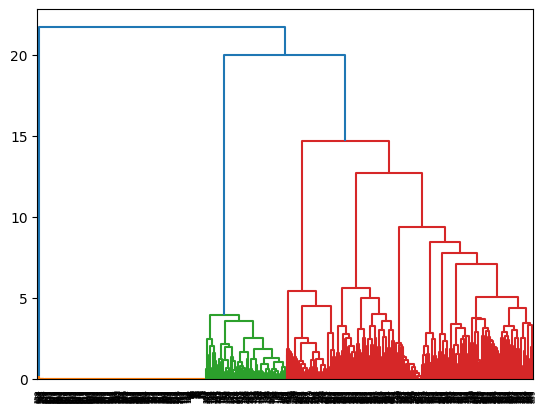

In [52]:
X = dendrogram(linkage_matrix)
#fig = ff.create_dendrogram(np.array(X["icoord"]))
#fig.update_layout(width=800, height=500)

In [53]:
t = 2.5

res = fcluster(linkage_matrix, criterion = "distance", t = t)
df = pd.DataFrame(res, index = pivot_combined.columns).reset_index()

### <a id='toc1_3_3_'></a>[Analysis of Sizing Features](#toc0_)

In order to understand how to clustering was done, we are taking a look at each cluster top sizes as well as size dimension.

The result has 25 clusters and the max cluster has 135 labels.

In [54]:
grouped_data = df.groupby(0)['catalog_id'].apply(list).reset_index()
grouped_data['catalog_id_length'] = grouped_data['catalog_id'].apply(lambda x: len(x))
grouped_data.head(5)

,0,catalog_id,catalog_id_length
0,1,"[19.0, 26.0, 87.0, 89.0, 94.0, 98.0, 99.0, 140...",291
1,2,"[120.0, 124.0, 229.0, 1030.0, 1037.0, 1067.0, ...",20
2,3,"[123.0, 179.0, 187.0, 192.0, 193.0, 195.0, 203...",33
3,4,"[11.0, 14.0, 18.0, 176.0, 178.0, 184.0, 185.0,...",86
4,5,"[259.0, 261.0, 263.0, 1787.0, 1816.0, 1817.0, ...",11


## <a id='toc1_4_'></a>[Visualizing the clusters](#toc0_)

### <a id='toc1_4_1_'></a>[t-Distributed Stochastic Neighbor Embedding (manifold embedding technique)](#toc0_)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a powerful dimensionality reduction technique used for visualizing high-dimensional data in lower-dimensional space. The main objectives of t-SNE are:
- Preservation of local structure (locality)
This means the points closer in high dimensional space should appear closer in a lower dimensional embedding.
- Robustness to noise and outliers
- Non linear embedding
Self explanatory. It captures complex non linear relationships in the data, suitable for visualization of intricate manifolds.
- Unsupervised learning

In [55]:
# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(pivot_combined.T)

pca_df = pd.DataFrame(data=X_tsne, 
                      columns=['PC1', 'PC2'], 
                      index = pivot_combined.T.index)

concat_df = pd.concat([pca_df, 
                       df.set_index("catalog_id")], 
                      ignore_index= False, 
                      axis=1)
concat_df = concat_df.rename(columns={0: 'Cluster'})
concat_df.index = concat_df.index.astype("str")

fig = px.scatter(concat_df, x='PC1', y='PC2', color='Cluster', title='t-SNE Plot')
fig

### <a id='toc1_4_2_'></a>[Visualizing the clustering on 2 dimensions using PCA](#toc0_)

PCA is a dimensionality reduction technique which can also be used to reduce the number of features in the dataset, while preserving its variance. PCA uses the covariance matrix and single value decomposition (SVD) to solve in order of the eigenvectors and eigen values of the covariance matrix. The eigen vectors represent the principal component (a new projection) and the eigenvalues the variance explained.

In this example, the variance explain by the 2 components is merely 30%, which means that there is a loss of 70% of the information.

In [56]:
pca = TruncatedSVD(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(pivot_combined.T)

# Convert the result to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index = pivot_combined.T.index)
concat_df = pd.concat([pca_df, df.set_index("catalog_id")], ignore_index= False, axis=1)
concat_df = concat_df.rename(columns={0: 'Cluster'})
concat_df.head(5)


,PC1,PC2,Cluster
catalog_id,,,
11.0,0.012785,1.572436,4
14.0,0.011580,1.628589,4
16.0,0.000021,0.000173,24
18.0,0.015696,1.490408,4
19.0,0.999782,-0.009129,1


In [57]:
# Get the percentage variance explained by each principal component
explained_var_ratio = pca.explained_variance_ratio_

# Create a scatter plot with Plotly
fig = px.scatter(concat_df, x='PC1', y='PC2', color='Cluster', title='PCA Scatter Plot')
fig.update_layout(
    xaxis_title=f'PC1 ({explained_var_ratio[0]*100:.2f}% Variance Explained)',
    yaxis_title=f'PC2 ({explained_var_ratio[1]*100:.2f}% Variance Explained)'
)

### <a id='toc1_4_3_'></a>[Comparison of the methods](#toc0_)

PCA **preserves the variance in the data**, whereas t-SNE **preserves the relationships between data points in a lower-dimensional space**, making it quite a good algorithm for visualizing complex high-dimensional data. In short, t-SNE is my go to in visualization in lower dimensional space whereas PCA is more useful as a preprocessing step/dimensionality reduction algorithm.

## <a id='toc1_5_'></a>[Analysis of the results](#toc0_)

Dropdown(description='Catalog ID:', options=([19.0, 26.0, 87.0, 89.0, 94.0, 98.0, 99.0, 140.0, 141.0, 143.0, 1…

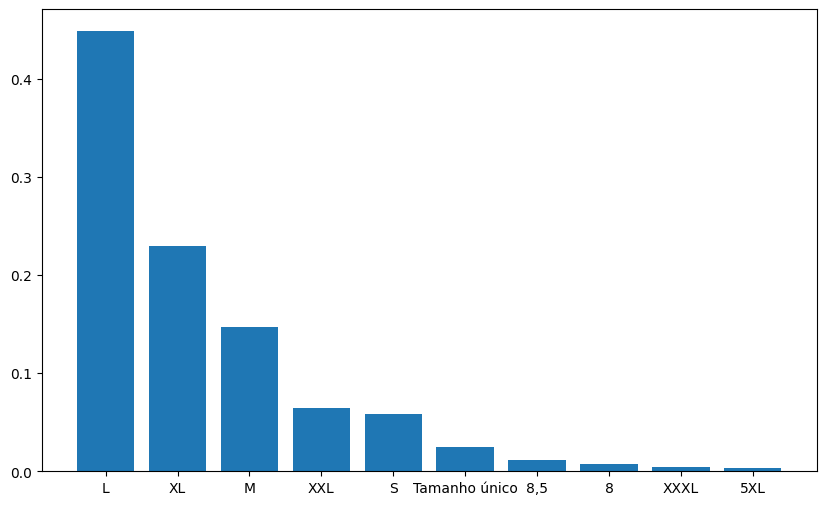

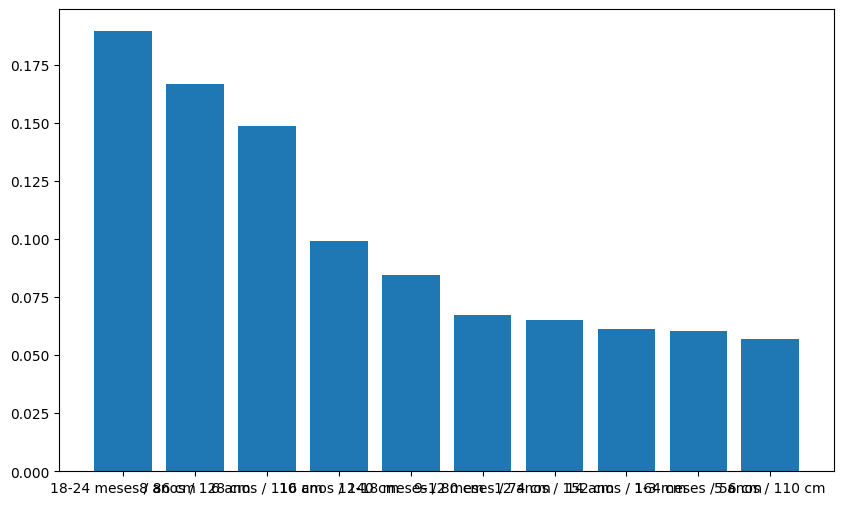

In [63]:
# Get unique catalog_id values
unique_catalog_ids = grouped_data["catalog_id"].tolist()

def update_graph(catalog_id):
    top_10 = pivot_combined[catalog_id].sum(axis=1).sort_values(ascending=False).head(10)
    top_10 /= top_10.sum()

    fig = plt.figure(figsize=(10, 6))
    plt.bar(top_10.index, top_10.values)
    plt.title(f"Top 10 for Catalog {catalog_id}")
    plt.xlabel("Index")
    plt.ylabel("Sum")
    plt.xticks(rotation=45)

catalog_dropdown = widgets.Dropdown(options=unique_catalog_ids, 
                                    description="Catalog ID:")
catalog_dropdown.observe(lambda change: update_graph(change.new), 
                         names="value")
display(catalog_dropdown)
